In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv(r"D:\sharook khan\Churn Prediction\customer_churn_dataset-training-master.csv")
df.shape

(440833, 12)

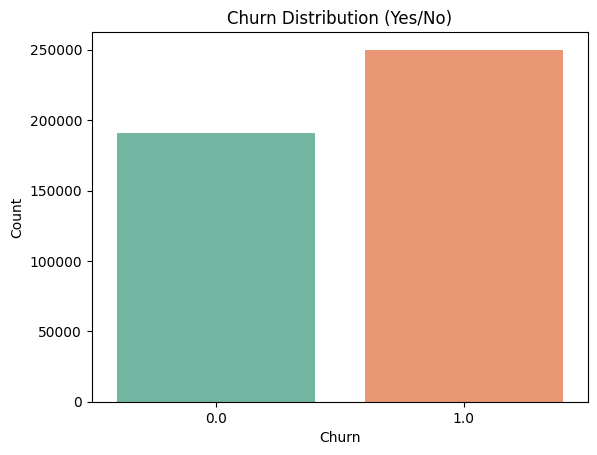

In [3]:
sns.countplot(x='Churn', data=df, palette='Set2')
plt.title('Churn Distribution (Yes/No)')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

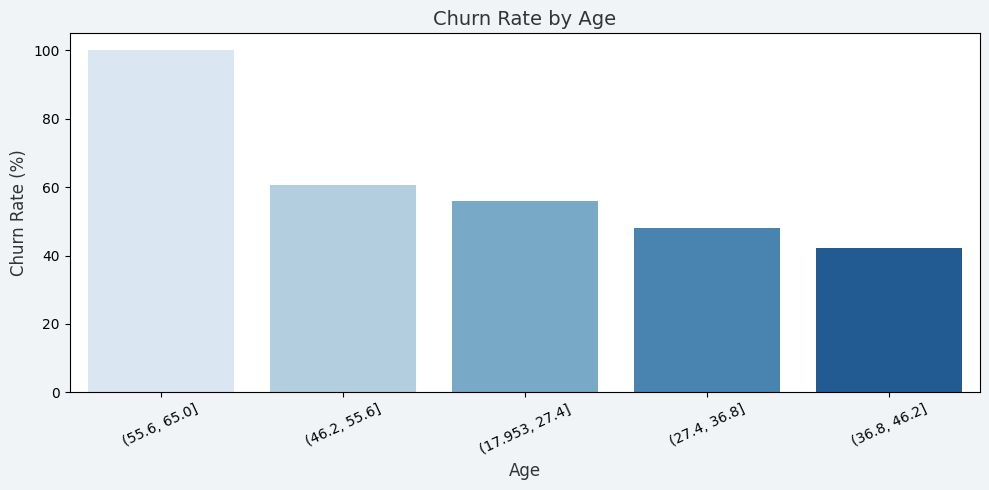

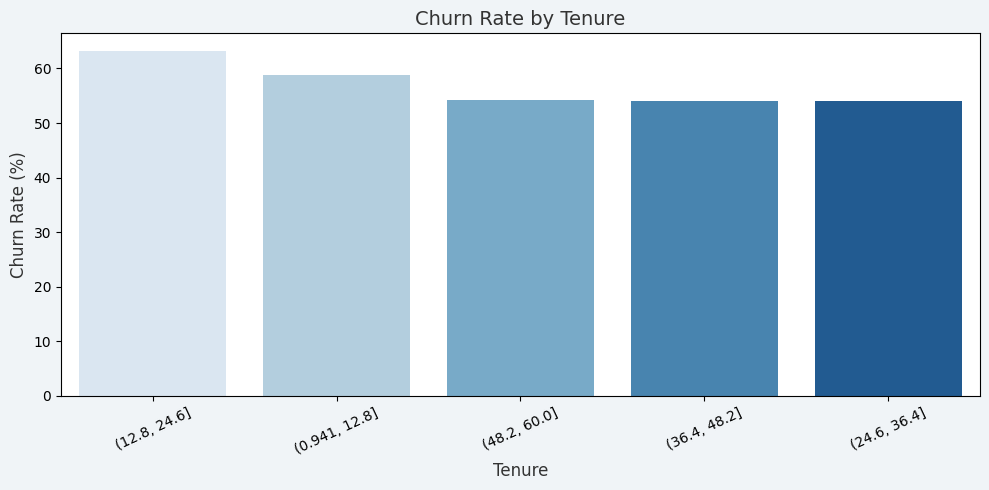

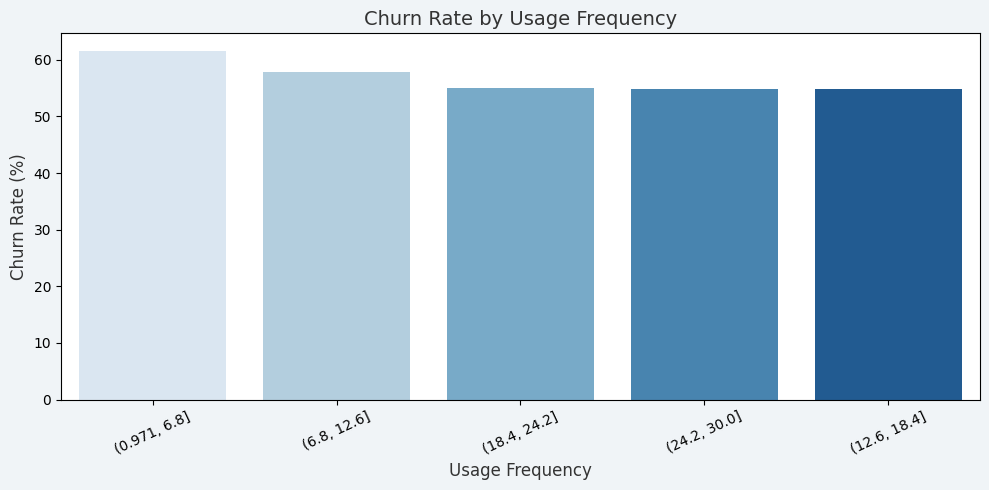

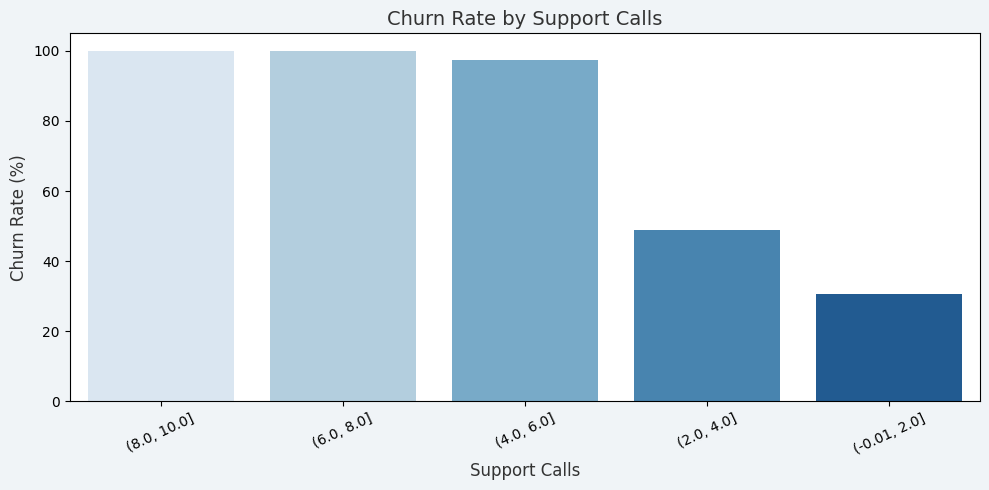

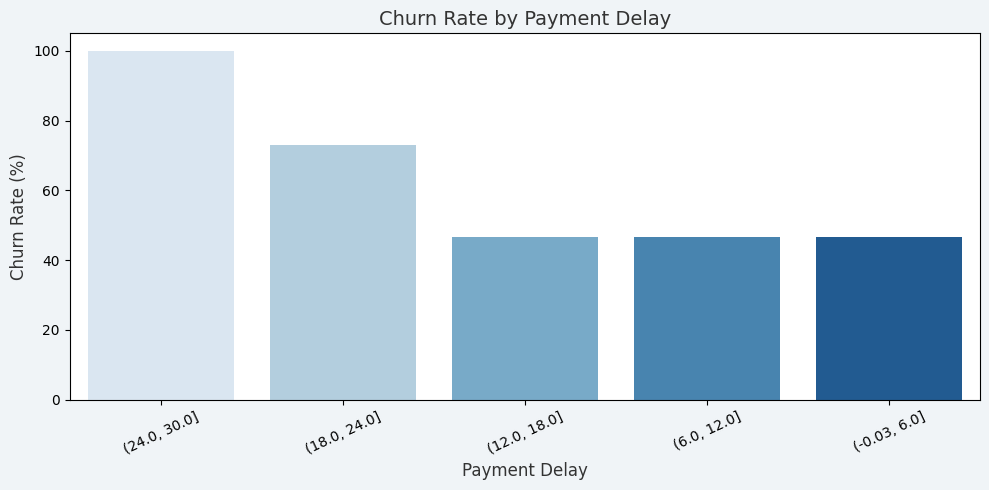

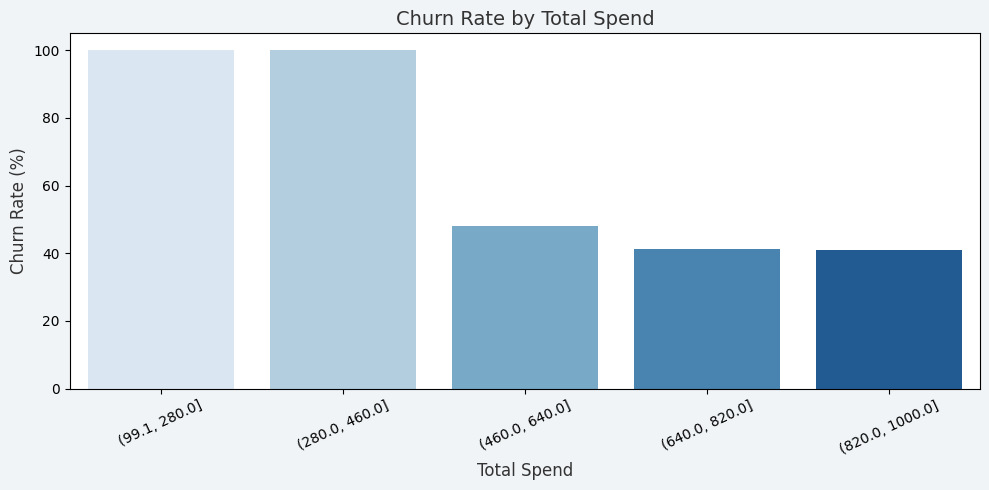

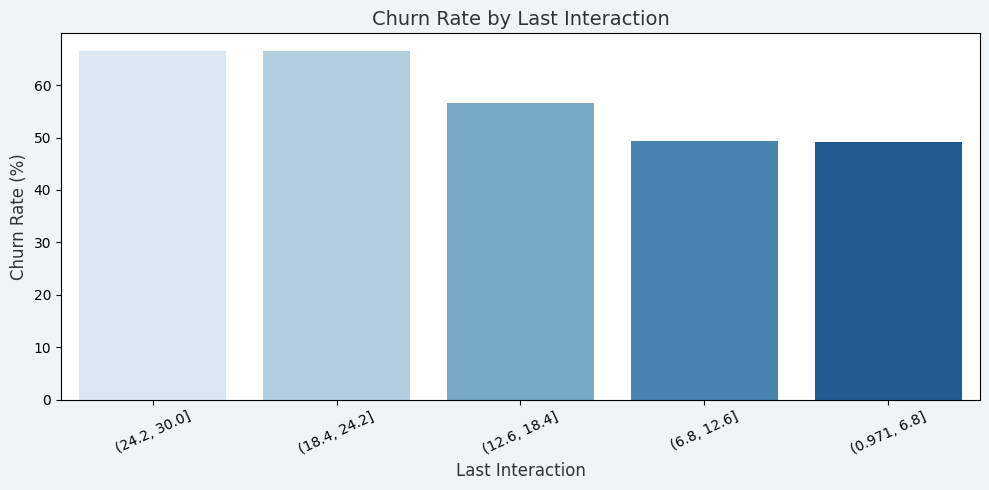

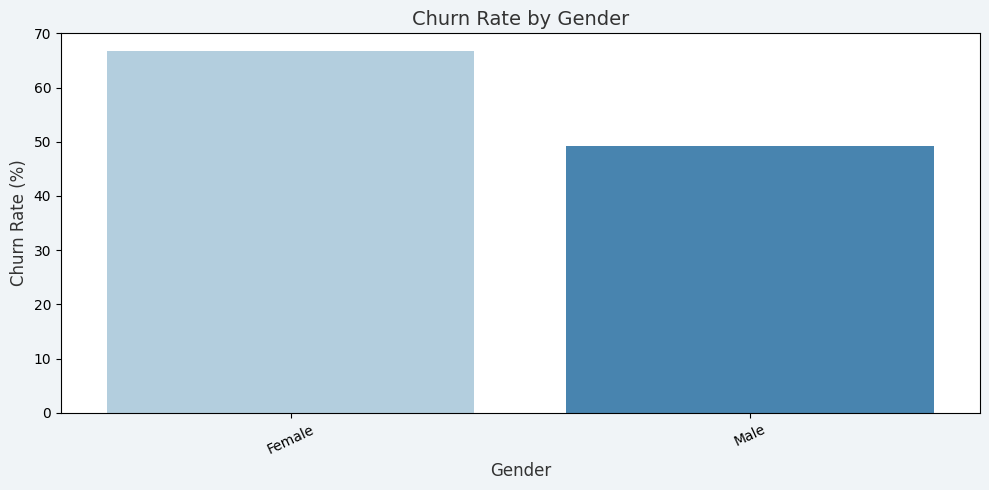

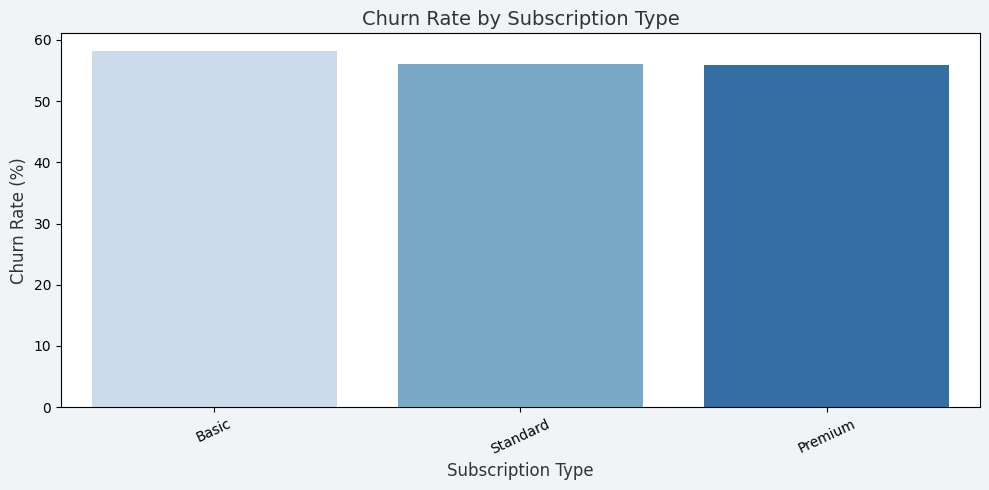

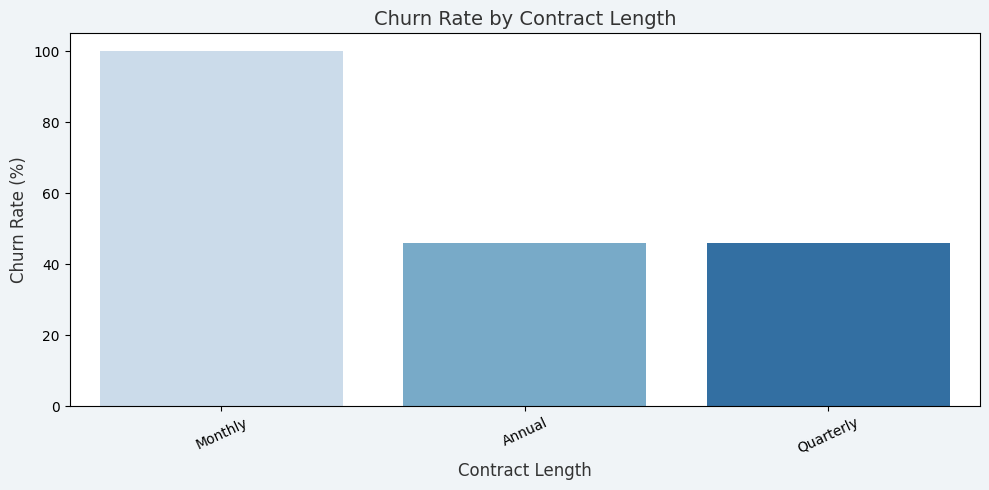

In [4]:
# Function to plot churn rate for a feature
def plot_churn_rate(feature, is_numerical=False, bins=5):
    if is_numerical:
        # Bin numerical data
        binned_feature = pd.cut(df[feature], bins)
        churn_rate = df.groupby(binned_feature)['Churn'].mean() * 100
    else:
        churn_rate = df.groupby(feature)['Churn'].mean() * 100
    
    # Sort values for better visualization
    churn_rate = churn_rate.sort_values(ascending=False)
    
    plt.figure(figsize=(10, 5), facecolor='#f0f4f7')
    sns.barplot(x=churn_rate.index.astype(str), y=churn_rate.values, palette="Blues")
    plt.title(f'Churn Rate by {feature}', color='#333333', fontsize=14)
    plt.xlabel(feature, color='#333333', fontsize=12)
    plt.ylabel('Churn Rate (%)', color='#333333', fontsize=12)
    plt.xticks(rotation=25, fontsize=10)
    plt.tight_layout()
    plt.show()

numerical_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']
categorical_features = ['Gender', 'Subscription Type', 'Contract Length']

# Plot churn rate for numerical features (binned)
for feature in numerical_features:
    plot_churn_rate(feature, is_numerical=True, bins=5)

# Plot churn rate for categorical features
for feature in categorical_features:
    plot_churn_rate(feature, is_numerical=False)

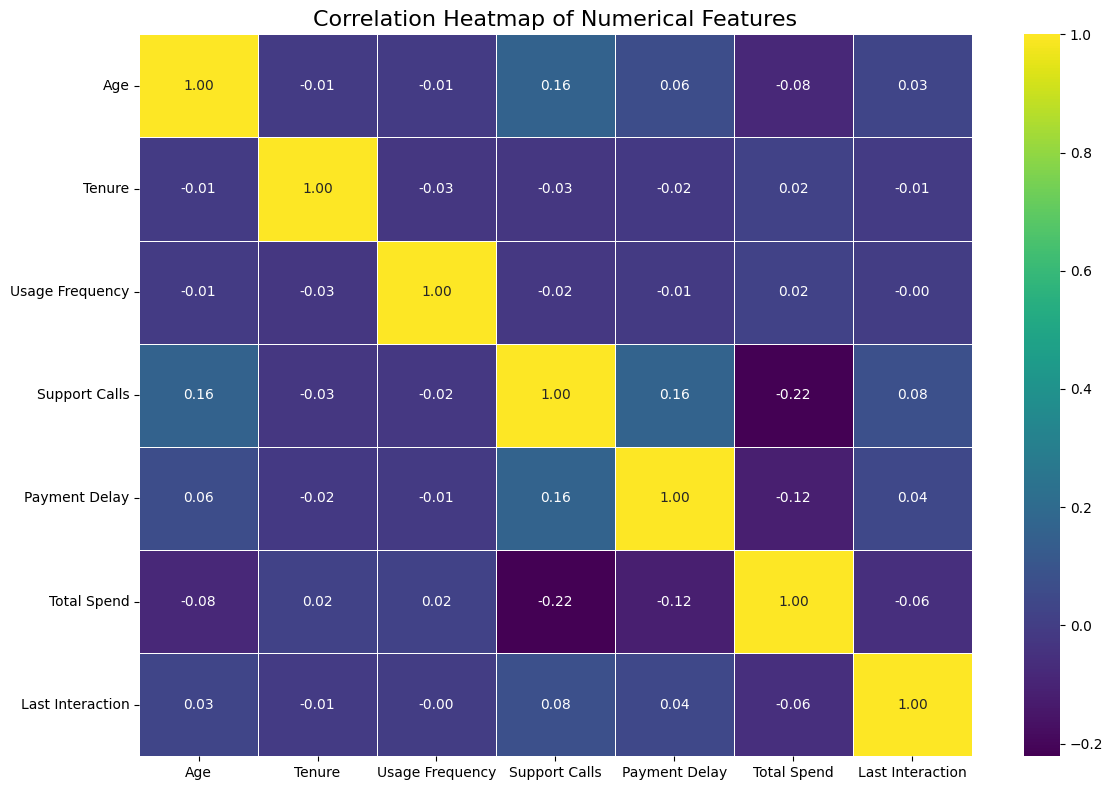

In [5]:
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

In [6]:
print(df['Churn'].isnull().sum())
#df['Churn'] = df['Churn'].fillna(df['Churn'].mean())  
df['Churn'] = df['Churn'].fillna(df['Churn'].mode()[0])  

1


In [7]:
# Split the data into features and target
X = df.drop(columns=['Churn'])
y = df['Churn']

# Convert categorical variables into dummy variables
X = pd.get_dummies(X, drop_first=True)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:

# Impute missing values in the features using the mean strategy
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Convert the imputed data back to DataFrame
X_train_imputed = pd.DataFrame(X_imputed, columns=X_train.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=X_test.columns)

# Standardize the imputed features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [9]:
# Check if there are any NaN values 
print("NaNs in X_train before removal:", X_train.isna().sum().sum())
print("NaNs in X_test before removal:", X_test.isna().sum().sum())

# Remove rows with NaN values 
X_train_clean = X_train.dropna()
X_test_clean = X_test.dropna()

# Remove corresponding labels where rows have been dropped
y_train_clean = y_train[X_train_clean.index]
y_test_clean = y_test[X_test_clean.index]

# Check if there are any NaN values left
print("NaNs in X_train after removal:", X_train_clean.isna().sum().sum())
print("NaNs in X_test after removal:", X_test_clean.isna().sum().sum())

NaNs in X_train before removal: 8
NaNs in X_test before removal: 0
NaNs in X_train after removal: 0
NaNs in X_test after removal: 0


In [10]:
selected_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
df = df[selected_features]

In [11]:
log_reg_model = LogisticRegression(max_iter=10)
log_reg_model.fit(X_train_scaled, y_train)

lr_pred_test = log_reg_model.predict(X_test_scaled)
lr_pred_train = log_reg_model.predict(X_train_scaled)

lr_accuracy_test = accuracy_score(y_test, lr_pred_test)
lr_accuracy_train = accuracy_score(y_train, lr_pred_train)

print(f'Logistic Regression Accuracy on Training Data: {lr_accuracy_train:.4f}')
print(f'Logistic Regression Accuracy on Test Data: {lr_accuracy_test:.4f}')
print('Classification Report on Test Data:')
print(classification_report(y_test, lr_pred_test))


Logistic Regression Accuracy on Training Data: 0.9808
Logistic Regression Accuracy on Test Data: 0.9811
Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98     38143
         1.0       0.98      0.98      0.98     50024

    accuracy                           0.98     88167
   macro avg       0.98      0.98      0.98     88167
weighted avg       0.98      0.98      0.98     88167



In [12]:
rf_model = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=5, min_samples_split=10, min_samples_leaf=5, max_features='sqrt')
rf_model.fit(X_train_scaled, y_train)

rf_pred_test = rf_model.predict(X_test_scaled)
rf_pred_train = rf_model.predict(X_train_scaled)

rf_accuracy_test = accuracy_score(y_test, rf_pred_test)
rf_accuracy_train = accuracy_score(y_train, rf_pred_train)

print(f'Random Forest Accuracy on Training Data: {rf_accuracy_train:.4f}')
print(f'Random Forest Accuracy on Test Data: {rf_accuracy_test:.4f}')
print('Classification Report on Test Data:')
print(classification_report(y_test, rf_pred_test))


Random Forest Accuracy on Training Data: 0.9916
Random Forest Accuracy on Test Data: 0.9917
Classification Report on Test Data:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     38143
         1.0       0.99      1.00      0.99     50024

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167



In [13]:
lgb_model = LGBMClassifier(
    n_estimators=4,         # Number of boosting rounds (trees)
    learning_rate=0.3,        # Step size at each iteration
    max_depth=5,              # Maximum depth of each tree
    subsample=1.0,            # Fraction of samples used to fit each tree
    colsample_bytree=0.5,     # Fraction of features used in each tree
    random_state=42
)
lgb_model.fit(X_train_scaled, y_train)
lgb_train_pred = lgb_model.predict(X_train_scaled)
lgb_test_pred = lgb_model.predict(X_test_scaled)
lgb_train_acc = accuracy_score(y_train, lgb_train_pred)
lgb_test_acc = accuracy_score(y_test, lgb_test_pred)

print(f"LightGBM Training Accuracy: {lgb_train_acc:.4f}")
print(f"LightGBM Test Accuracy: {lgb_test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, lgb_test_pred))

[LightGBM] [Info] Number of positive: 199976, number of negative: 152690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008240 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 352666, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567041 -> initscore=0.269788
[LightGBM] [Info] Start training from score 0.269788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Training Accuracy: 0.9800
LightGBM Test Accuracy: 0.9787

Classification Report:
              precision    recall  f1-score   suppor

In [26]:
knn_model = KNeighborsClassifier(n_neighbors=5)  
knn_model.fit(X_train_scaled, y_train)
knn_train_pred = knn_model.predict(X_train_scaled)
knn_test_pred = knn_model.predict(X_test_scaled)

knn_train_acc = accuracy_score(y_train, knn_train_pred)
knn_test_acc = accuracy_score(y_test, knn_test_pred)

print(f"KNN Training Accuracy: {knn_train_acc:.4f}")
print(f"KNN Test Accuracy: {knn_test_acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, knn_test_pred))

KNN Training Accuracy: 0.9912
KNN Test Accuracy: 0.9879

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     38143
         1.0       0.99      0.98      0.99     50024

    accuracy                           0.99     88167
   macro avg       0.99      0.99      0.99     88167
weighted avg       0.99      0.99      0.99     88167



In [15]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

log_reg_model = LogisticRegression(max_iter=10, random_state=42)
rf_model = RandomForestClassifier(n_estimators=300, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt', random_state=42)
lgb_model = LGBMClassifier(n_estimators=4, learning_rate=0.1, max_depth=1, subsample=0.5, colsample_bytree=0.5, random_state=42)
knn_model = KNeighborsClassifier(n_neighbors=5)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_reg_model),
        ('rf', rf_model),
        ('lgb', lgb_model),
        ('knn', knn_model)
    ],
    voting='hard'
)

voting_clf.fit(X_train_scaled, y_train)

voting_pred_test = voting_clf.predict(X_test_scaled)
voting_pred_train = voting_clf.predict(X_train_scaled)

voting_acc_test = accuracy_score(y_test, voting_pred_test)
voting_acc_train = accuracy_score(y_train, voting_pred_train)

print(f"Voting Classifier Accuracy on Training Data: {voting_acc_train:.4f}")
print(f"Voting Classifier Accuracy on Test Data: {voting_acc_test:.4f}")

print("\nClassification Report on Test Data:")
print(classification_report(y_test, voting_pred_test))


[LightGBM] [Info] Number of positive: 199976, number of negative: 152690
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 352666, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567041 -> initscore=0.269788
[LightGBM] [Info] Start training from score 0.269788
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Voting Classifier Accuracy on Training Data: 0.9886
Voting Classifier Accuracy on Test Data: 0.9869

Classification Report on Test Data:
     

In [16]:
#import joblib
#joblib.dump(voting_clf,'model.pkl')

In [17]:
import joblib

# Apply feature selection before scaling
selected_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction', 'Churn']
df_selected = df[selected_features]

# Split the data into features and target
X = df_selected.drop(columns=['Churn'])
y = df_selected['Churn']

# Convert categorical variables into dummy variables
X = pd.get_dummies(X, drop_first=True)

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Convert the imputed data back to DataFrame
X_imputed = pd.DataFrame(X_imputed, columns=X.columns)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Save the scaler as a .pkl file using joblib
#joblib.dump(scaler, 'scaler.pkl')

# Optionally, save the imputer as well, if needed
#joblib.dump(imputer, 'imputer.pkl')

# Now you can use the scaler.pkl file to scale new data during inference

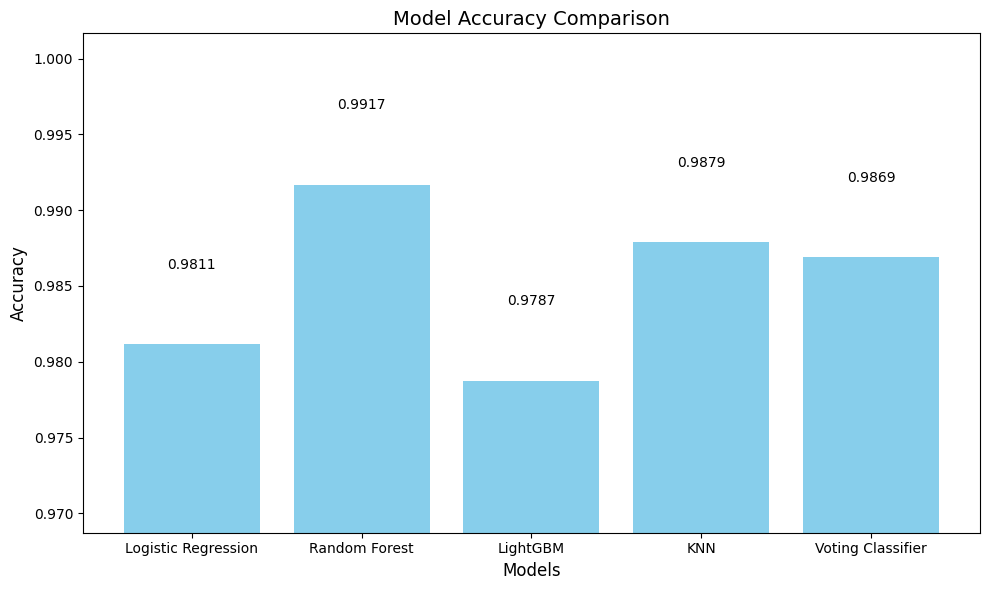

In [27]:

model_names = ['Logistic Regression', 'Random Forest', 'LightGBM', 'KNN', 'Voting Classifier']
accuracies = [lr_accuracy_test, rf_accuracy_test, lgb_test_acc, knn_test_acc, voting_acc_test]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue')  

plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.ylim([min(accuracies) - 0.01, max(accuracies) + 0.01])  

for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy + 0.005, f'{accuracy:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


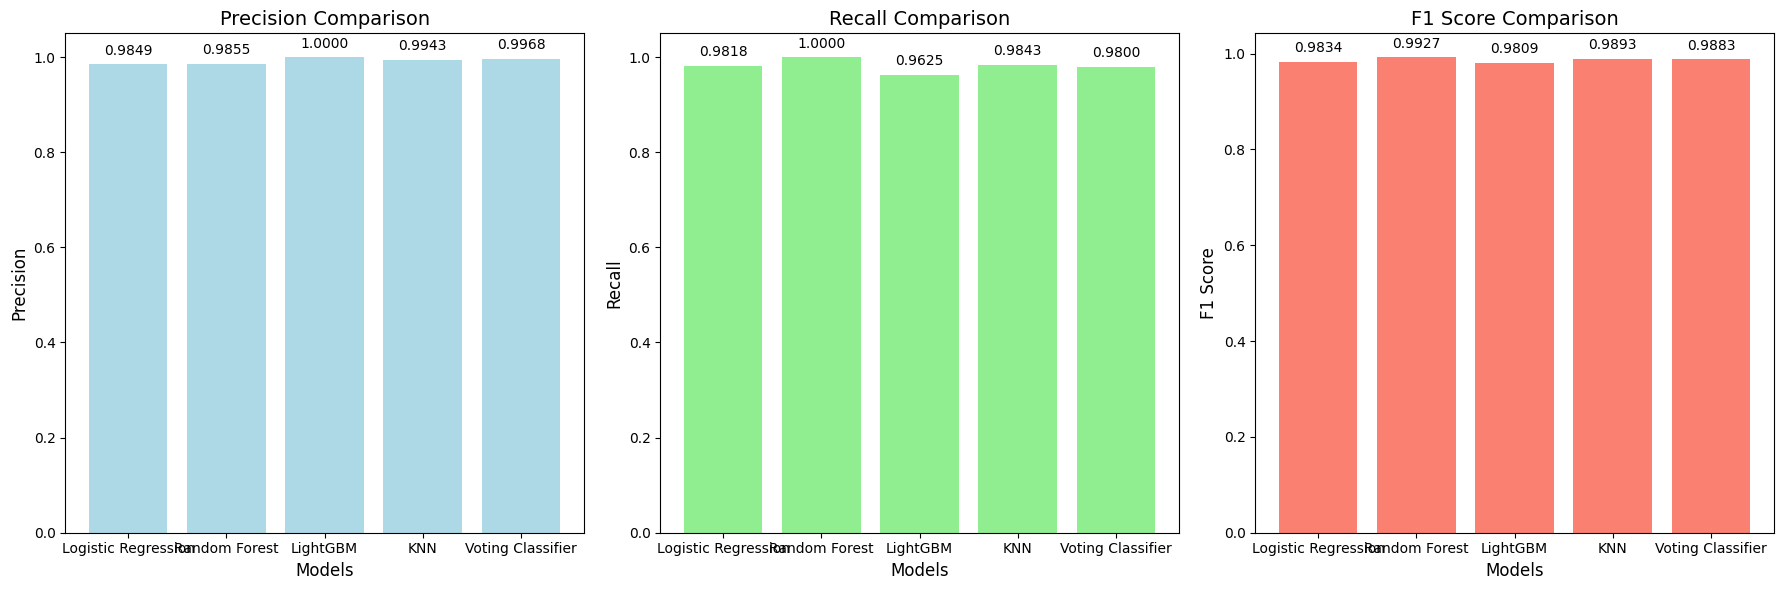

In [28]:
models = ['Logistic Regression', 'Random Forest', 'LightGBM', 'KNN', 'Voting Classifier']
predictions = [lr_pred_test, rf_pred_test, lgb_test_pred, knn_test_pred, voting_pred_test]

# Calculate precision, recall, and f1 score for each model
precision = [precision_score(y_test, pred) for pred in predictions]
recall = [recall_score(y_test, pred) for pred in predictions]
f1 = [f1_score(y_test, pred) for pred in predictions]

# Create bar graphs for Precision, Recall, and F1 Score
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision graph
axes[0].bar(models, precision, color='lightblue')
axes[0].set_title('Precision Comparison', fontsize=14)
axes[0].set_xlabel('Models', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)

# Recall graph
axes[1].bar(models, recall, color='lightgreen')
axes[1].set_title('Recall Comparison', fontsize=14)
axes[1].set_xlabel('Models', fontsize=12)
axes[1].set_ylabel('Recall', fontsize=12)

# F1 Score graph
axes[2].bar(models, f1, color='salmon')
axes[2].set_title('F1 Score Comparison', fontsize=14)
axes[2].set_xlabel('Models', fontsize=12)
axes[2].set_ylabel('F1 Score', fontsize=12)

# Display the values on top of the bars
for ax, metric, color in zip(axes, [precision, recall, f1], ['lightblue', 'lightgreen', 'salmon']):
    for i, value in enumerate(metric):
        ax.text(i, value + 0.02, f'{value:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


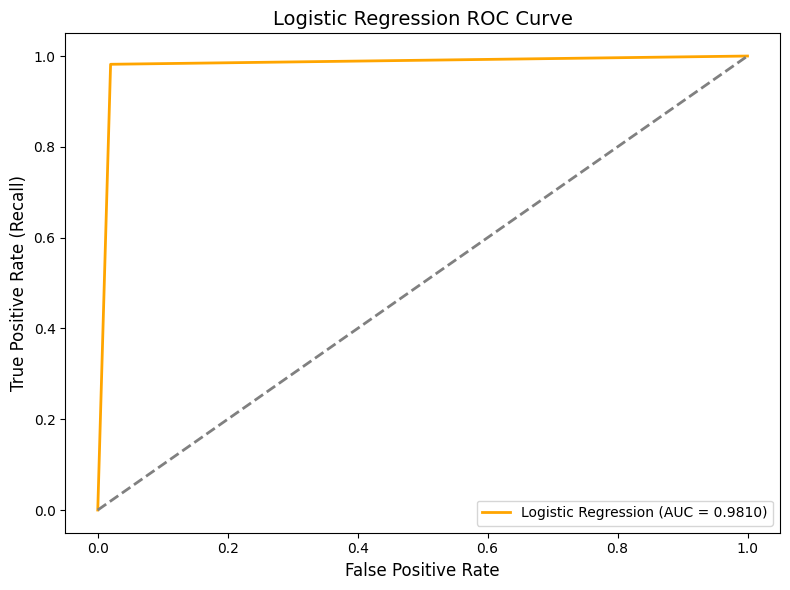

In [20]:
y_true = y_test  
# Logistic Regression ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_true, lr_pred_test)
auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='orange', lw=2, label=f'Logistic Regression (AUC = {auc_lr:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Logistic Regression ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


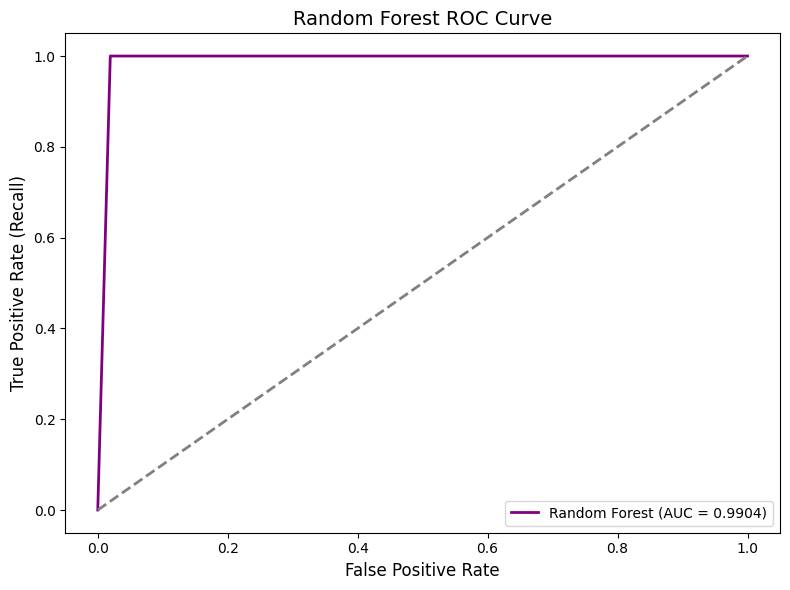

In [21]:
# Random Forest ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_true, rf_pred_test)
auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='purple', lw=2, label=f'Random Forest (AUC = {auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Random Forest ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

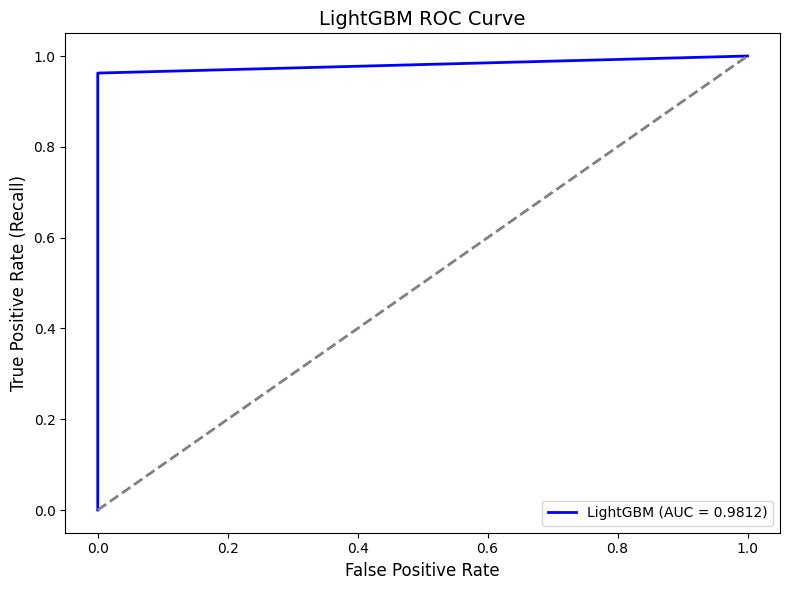

In [22]:
# LightGBM ROC curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_true, lgb_test_pred)
auc_lgb = auc(fpr_lgb, tpr_lgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgb, tpr_lgb, color='blue', lw=2, label=f'LightGBM (AUC = {auc_lgb:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('LightGBM ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


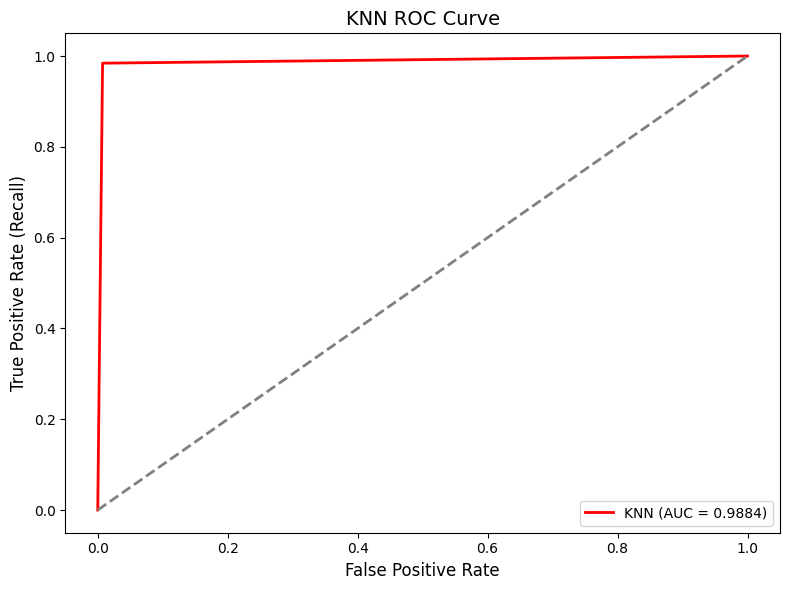

In [29]:
# KNN ROC curve
fpr_knn, tpr_knn, _ = roc_curve(y_true, knn_test_pred)
auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label=f'KNN (AUC = {auc_knn:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('KNN ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

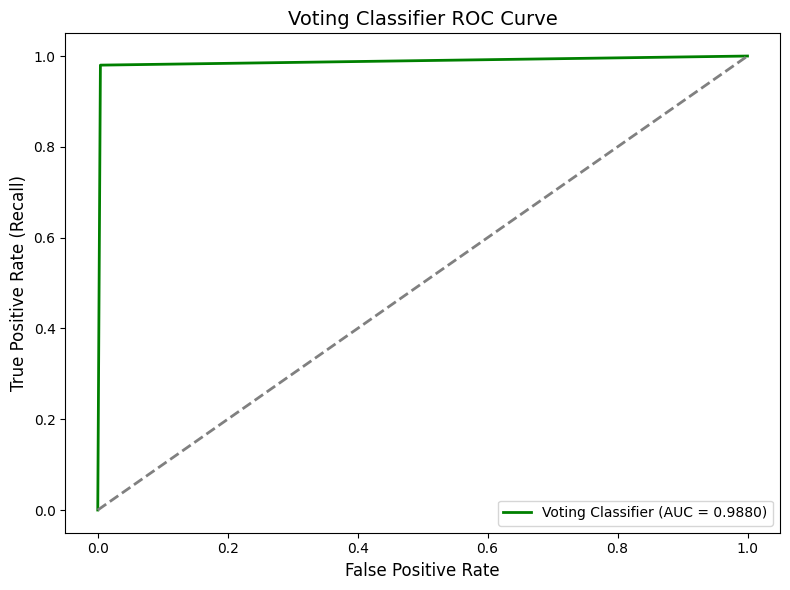

In [24]:
# Voting Classifier ROC curve
fpr_voting, tpr_voting, _ = roc_curve(y_true, voting_pred_test)
auc_voting = auc(fpr_voting, tpr_voting)

plt.figure(figsize=(8, 6))
plt.plot(fpr_voting, tpr_voting, color='green', lw=2, label=f'Voting Classifier (AUC = {auc_voting:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('Voting Classifier ROC Curve', fontsize=14)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [25]:
import pandas as pd
from sklearn.metrics import classification_report

# Assuming you have your prediction results ready
# Example placeholders (replace with your actual values)
lr_report = classification_report(y_test, lr_pred_test, output_dict=True)
rf_report = classification_report(y_test, rf_pred_test, output_dict=True)
lgb_report = classification_report(y_test, lgb_test_pred, output_dict=True)
knn_report = classification_report(y_test, knn_test_pred, output_dict=True)
voting_report = classification_report(y_test, voting_pred_test, output_dict=True)

# Convert reports to DataFrames for tabular format
reports = {
    'Logistic Regression': pd.DataFrame(lr_report).transpose(),
    'Random Forest': pd.DataFrame(rf_report).transpose(),
    'LightGBM': pd.DataFrame(lgb_report).transpose(),
    'KNN': pd.DataFrame(knn_report).transpose(),
    'Voting Classifier': pd.DataFrame(voting_report).transpose()
}

# Concatenate them side by side for a better comparison
combined_report = pd.concat(reports.values(), axis=1, keys=reports.keys())

# Round the values to 4 decimal places
combined_report = combined_report.round(4)

# Display the combined report
combined_report


Logistic Regression                              Random Forest  \
                       precision  recall f1-score     support     precision   
0.0                       0.9763  0.9803   0.9783  38143.0000        1.0000   
1.0                       0.9849  0.9818   0.9834  50024.0000        0.9855   
accuracy                  0.9811  0.9811   0.9811      0.9811        0.9917   
macro avg                 0.9806  0.9810   0.9808  88167.0000        0.9928   
weighted avg              0.9812  0.9811   0.9812  88167.0000        0.9918   

                                           LightGBM                   \
              recall f1-score     support precision  recall f1-score   
0.0           0.9807   0.9903  38143.0000    0.9531  1.0000   0.9760   
1.0           1.0000   0.9927  50024.0000    1.0000  0.9625   0.9809   
accuracy      0.9917   0.9917      0.9917    0.9787  0.9787   0.9787   
macro avg     0.9904   0.9915  88167.0000    0.9766  0.9812   0.9784   
weighted avg  0.9917   0.9917  88167.0000    0.9797  0.9787   0.9788   

                               KNN                               \
                 support precision  recall f1-score     support   
0.0           38143.0000    0.9796  0.9926   0.9861  38143.0000   
1.0           50024.0000    0.9943  0.9843   0.9893  50024.0000   
accuracy          0.9787    0.9879  0.9879   0.9879      0.9879   
macro avg     88167.0000    0.9870  0.9884   0.9877  88167.0000   
weighted avg  88167.0000    0.9880  0.9879   0.9879  88167.0000   

             Voting Classifier                               
                     precision  recall f1-score     support  
0.0                     0.9743  0.9959   0.9850  38143.0000  
1.0                     0.9968  0.9800   0.9883  50024.0000  
accuracy                0.9869  0.9869   0.9869      0.9869  
macro avg               0.9856  0.9880   0.9867  88167.0000  
weighted avg            0.9871  0.9869   0.9869  88167.0000